***Gaussian Process with monotonicity constraint.***
=====

In [1]:
import pystan
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn import preprocessing
import pickle
from hashlib import md5
import GPy
import time

def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    code_hash = md5(model_code.encode('ascii')).hexdigest()
    if model_name is None:
        cache_fn = 'pkl_cache/cached-model-{}.pkl'.format(code_hash)
    else:
        cache_fn = 'pkl_cache/cached-{}-{}.pkl'.format(model_name, code_hash)
    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except:
        sm = pystan.StanModel(model_code=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else:
        print("Using cached StanModel")
    return sm

In [2]:
prior_code = """
functions {
    matrix joint_cov(real[] x,real alpha,real rho,real delta) {
        int N = size(x);
        matrix[N, N] K;
        real sq_alpha = square(alpha);
        for (i in 1:(N-1)) {
            K[i, i] = sq_alpha + delta;
            for (j in (i + 1):N) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho));
                K[j, i] = K[i, j];
            }
        }
        K[N,N] = sq_alpha + delta;
        return cholesky_decompose(K);
    }
}


data {
    int<lower=1> N;
    real x1[N];
}

transformed data {
    vector[N] mu;
    real delta=1e-8;
    mu=rep_vector(0,N);
}

parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
    vector[N] eta;
}

transformed parameters{
    matrix[N, N] L_K;
    {
        L_K = joint_cov(x1,alpha,rho,delta);
    }
}

model {    
    rho ~ inv_gamma(5,5);
    alpha ~ normal(0, 1);
    eta ~ normal(0, 1);
}

generated quantities {
    vector[N] f;
    f = mu + L_K*eta;
}
"""


In [3]:
prior_model = StanModel_cache(model_code=prior_code)

Using cached StanModel


In [4]:
mono_prior_code = """
functions {
    matrix joint_cov(real[] x,real alpha,real rho,real delta,int N1) {
        int N = size(x);
        int Nm = N-N1;
        matrix[N, N] K;
        real sq_alpha = square(alpha);
        for (i in 1:(N1-1)) {
            K[i, i] = sq_alpha + delta;
            for (j in (i + 1):N1) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho));
                K[j, i] = K[i, j];
            }
        }
        K[N1, N1] = sq_alpha + delta;
        
        for (i in (N1+1):N) {
            for (j in 1:N1) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho)) * ((x[j] - x[i])/ square(rho)) ;
                K[j, i] = K[i, j];
            }
        }
        
        for (i in (N1+1):(N-1)) {
            K[i, i] = (sq_alpha /square(rho))+ delta;
            for (j in (i+1):N) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho)) * ((1-square((x[i] - x[j])/ rho))/square(rho));
                K[j, i] = K[i, j];
            }
        }
        K[N, N] = (sq_alpha/square(rho)) + delta;
        return cholesky_decompose(K);
    }
}


data {
    int<lower=1> N1;
    real x1[N1];
    int<lower=1> Nm;
    real xm[Nm];
    int m[Nm];
    real v;
}

transformed data {
    int<lower=1> N = N1 + Nm;
    vector[N] mu;
    real delta=1e-5;
    real x[N];
    
    
    for (n in 1:N1) x[n] = x1[n];
    for (n in 1:Nm) x[N1 + n] = xm[n];
    mu=rep_vector(0,N);
    
}

parameters {
    real<lower=0.00001> rho;
    real<lower=0.00001> alpha;
    vector[N] eta;
    
}

transformed parameters{
    vector[N] f;
    {
        matrix[N, N] L_K;
        L_K = joint_cov(x,alpha,rho,delta,N1);
        f = mu + L_K*eta;
    }
}

model {    
    rho ~ inv_gamma(5,5);
    alpha ~ normal(0, 1);
    eta ~ normal(0, 1);
    m ~ bernoulli_logit(f[N1+1:N]./v);
}
"""


In [5]:
mono_prior_model = StanModel_cache(model_code=mono_prior_code)

Using cached StanModel


In [6]:
cnt_xp = 66
xp = np.linspace(-5,5,cnt_xp)

prior_data = dict(
    N = len(xp),
    x1 = xp
)

In [7]:
prior_fit = prior_model.sampling(data=prior_data)
print(prior_fit)

Inference for Stan model: anon_model_991732671532ef55a0f3b3cf600b2f78.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho          1.26    0.01   0.73   0.49   0.79   1.08   1.52   3.03   4000    1.0
alpha         0.8  9.5e-3    0.6   0.03   0.32   0.68   1.14    2.2   4000    1.0
eta[0]       0.02    0.02   1.01  -1.96  -0.67   0.02    0.7   2.02   4000    1.0
eta[1]      -0.01    0.02   1.02  -2.05   -0.7  -0.02    0.7    2.0   4000    1.0
eta[2]     7.7e-3    0.02   0.99  -1.95  -0.66 5.9e-3   0.68   1.93   4000    1.0
eta[3]      -0.01    0.02    1.0  -1.96   -0.7  -0.01   0.68   1.94   4000    1.0
eta[4]    -4.6e-3    0.02   0.98  -1.93  -0.66-7.1e-4   0.65   1.95   4000    1.0
eta[5]    -9.6e-3    0.02    1.0  -2.01  -0.69 6.1e-3   0.66   1.96   4000    1.0
eta[6]    -7.0e-3    0.02   1.01  -1.95   -0.7  -0.01   0.68   1.97   400

In [52]:
prior_arr = prior_fit.extract(permuted=True)
prior = prior_arr['f']

In [10]:
cnt_m = 66
xm = np.linspace(-5,5,cnt_m)
m = np.ones_like(xm,dtype=int)
v_value = 0.000001

In [11]:
mono_prior_data = dict(
    N1 = len(xp),
    x1 = xp,
    Nm = cnt_m,
    xm = xm,
    m = m,
    v = v_value
)

In [12]:
mono_prior_fit = mono_prior_model.sampling(data=mono_prior_data)
print(mono_prior_fit)

Inference for Stan model: anon_model_ab232ab83d8d4f265aadc82c340929cc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho        4.33     0.3   2.13   1.89   2.83   3.73   5.36   9.56     50   1.07
alpha      0.86    0.05   0.55   0.13   0.43   0.77   1.18   2.11    133   1.05
eta[0]    -0.98    0.12   0.78  -2.49  -1.54  -0.91  -0.38   0.42     46   1.09
eta[1]     0.66    0.09   0.57  -0.12   0.23   0.51    1.0   2.04     42    1.1
eta[2]     0.08    0.13    0.9  -1.86  -0.54   0.11   0.74   1.75     46   1.16
eta[3]    -0.02    0.13   0.89  -1.86  -0.54   0.04   0.57    1.6     45   1.05
eta[4]    -0.13    0.13   1.02  -2.36  -0.82  -0.11   0.65   1.64     66   1.03
eta[5]    -0.09    0.17   0.99  -1.91  -0.83  -0.17    0.6   1.96     35   1.11
eta[6]    -0.03    0.12   0.96  -1.88  -0.71  -0.08   0.62   1.88     68   1.05
eta[7]    -

In [51]:
mono_prior_arr = mono_prior_fit.extract(permuted=True)
sim_mono_prior = mono_prior_arr['f']

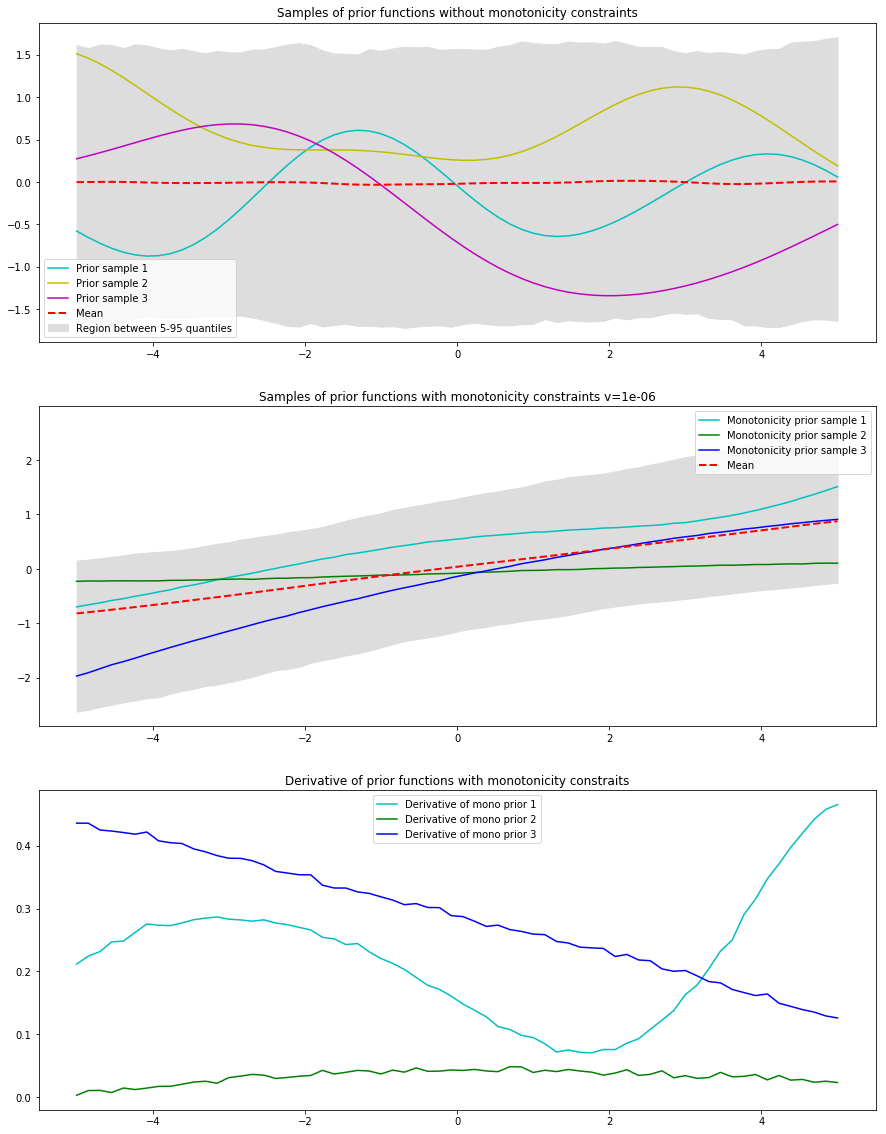

In [50]:
p = np.random.randint(sim_mono_prior.shape[0],size=3)
pp = np.random.randint(prior.shape[0],size=3)
pr_q5 = np.percentile(prior,5,axis=0)
pr_q95 = np.percentile(prior,95,axis=0)
pr_mean = np.mean(prior,axis=0)
m_pr_q5 = np.percentile(sim_mono_prior[0:,:cnt_xp],5,axis=0)
m_pr_q95 = np.percentile(sim_mono_prior[0:,:cnt_xp],95,axis=0)
m_pr_mean = np.mean(sim_mono_prior[0:,:cnt_xp],axis=0)


plt.figure(figsize=(15,20))

plt.subplot(311)
plt.title('Samples of prior functions without monotonicity constraints')
plt.plot(xp, prior[pp[0]], 'c',label="Prior sample 1")
plt.plot(xp, prior[pp[1]], 'y',label="Prior sample 2")
plt.plot(xp, prior[pp[2]], 'm',label="Prior sample 3")
plt.fill_between(xp, pr_q5, pr_q95, color="#dddddd",label="Region between 5-95 quantiles")
plt.plot(xp,pr_mean,'r--',lw=2,label="Mean" )
plt.legend()


plt.subplot(312)
plt.title('Samples of prior functions with monotonicity constraints v={}'.format(v_value))
plt.plot(xp, sim_mono_prior[p[0]][:cnt_xp], 'c',label="Monotonicity prior sample 1")
plt.plot(xp, sim_mono_prior[p[1]][:cnt_xp], 'g',label="Monotonicity prior sample 2")
plt.plot(xp, sim_mono_prior[p[2]][:cnt_xp], 'b',label="Monotonicity prior sample 3")
plt.fill_between(xp, m_pr_q5, m_pr_q95, color="#dddddd")
plt.plot(xp,m_pr_mean,'r--',lw=2,label="Mean" )
plt.legend()

plt.subplot(313)
plt.title('Derivative of prior functions with monotonicity constraits')
plt.plot(xm, sim_mono_prior[p[0]][cnt_xp:], 'c',label="Derivative of mono prior 1")
plt.plot(xm, sim_mono_prior[p[1]][cnt_xp:], 'g',label="Derivative of mono prior 2")
plt.plot(xm, sim_mono_prior[p[2]][cnt_xp:], 'b',label="Derivative of mono prior 3")
plt.legend()


plt.legend()
plt.savefig("Prior %s.png"%(time.ctime()))
plt.show()

# Posterior 

In [16]:
posterior_code = """
functions {
    matrix joint_cov(real[] x,real alpha,real rho,real delta) {
        int N = size(x);
        matrix[N, N] K;
        real sq_alpha = square(alpha);
        for (i in 1:(N-1)) {
            K[i, i] = sq_alpha + delta;
            for (j in (i + 1):N) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho));
                K[j, i] = K[i, j];
            }
        }
        K[N, N] = sq_alpha + delta;
        return cholesky_decompose(K);
    }
}

data {
    int<lower=1> N1;
    real x1[N1];
    vector[N1] y1;
    int<lower=1> N2;
    real x2[N2];
    real sig_var;
}

transformed data {
    vector[N1] mu;
    int<lower=1> N = N1 + N2;
    real x[N];
    real delta=1e-8;
    
    for (n in 1:N1) x[n] = x1[n];
    for (n in 1:N2) x[N1 + n] = x2[n];
    mu=rep_vector(0,N1);
}

parameters {
    real<lower=0> rho;
    real<lower=0> alpha;
    vector[N] eta;
    real<lower=0.000001> sigma;
}

transformed parameters{
     vector[N] f;
    {
        matrix[N, N] L_K = joint_cov(x,alpha,rho,delta);
        f = L_K * eta;
    }
}


model {    
    rho ~ inv_gamma(1, 2);
    alpha ~ normal(0, 1);
    sigma ~ normal(0,sig_var);
    eta ~ normal(0, 1);
    y1 ~ normal(f[1:N1], sigma);
}

generated quantities {
    vector[N2] y2;
    for(n in 1:N2)
        y2[n] = normal_rng(f[N1+n], sigma);
}
"""


In [17]:
posterior_model = StanModel_cache(model_code=posterior_code)

Using cached StanModel


In [18]:
mono_posterior_code = """
functions {
    matrix joint_cov(real[] x,real alpha,real rho,real delta,int Nm,int N) {
        int N1 = N-Nm;
        matrix[N, N] K;
        real sq_alpha = square(alpha);
        for (i in 1:(N1-1)) {
            K[i, i] = sq_alpha + delta;
            for (j in (i + 1):N1) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho));
                K[j, i] = K[i, j];
            }
        }
        K[N1, N1] = sq_alpha + delta;
        
        for (i in (N1+1):N) {
            for (j in 1:N1) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho)) * ((x[j] - x[i])/ square(rho)) ;
                K[j, i] = K[i, j];
            }
        }
        
        for (i in (N1+1):(N-1)) {
            K[i, i] = (sq_alpha /square(rho))+ delta;
            for (j in (i+1):N) {
                K[i, j] = sq_alpha * exp(-0.5 * square((x[i] - x[j])/ rho)) * ((1-square((x[i] - x[j])/ rho))/square(rho));
                K[j, i] = K[i, j];
            }
        }
        K[N, N] = (sq_alpha/square(rho)) + delta;        
        return cholesky_decompose(K);
    }
}


data {
    int<lower=1> N1;
    real x1[N1];
    vector[N1] y1;
    int<lower=1> Nm;
    real xm[Nm];
    int m[Nm];
    int<lower=1> N2;
    real x2[N2];
    real sig_var;
    real v;
}

transformed data {
    int<lower=1> N = N1 + Nm + N2;
    vector[N] mu;
    real delta=1e-5;
    real x[N];
    
    
    for (n in 1:N1) x[n] = x1[n];
    for (n in 1:N2) x[N1 + n] = x2[n];
    for (n in 1:Nm) x[N1+N2 + n] = xm[n];
    mu=rep_vector(0,N);
    
}

parameters {
    real<lower=0.00001> rho;
    real<lower=0.00001> alpha;
    vector[N] eta;
    real<lower=0.000001> sigma;
    
}

transformed parameters{
    vector[N] f;
    {
        matrix[N, N] L_K;
        L_K = joint_cov(x,alpha,rho,delta,Nm,N);
        f = mu + L_K*eta;
    }
}

model {    
    rho ~ inv_gamma(1,2);
    alpha ~ normal(0, 1);
    eta ~ normal(0, 1);
    sigma ~ normal(0,sig_var);
    y1 ~ normal(f[1:N1], sigma);
    m ~ bernoulli_logit(f[N1+N2+1:N]./v);
}

generated quantities{
    vector[N2] y2;
    for(n in 1:N2)
        y2[n] = normal_rng(f[N1+n],sigma);
}
"""

In [19]:
mono_posterior_model = StanModel_cache(model_code=mono_posterior_code)

Using cached StanModel


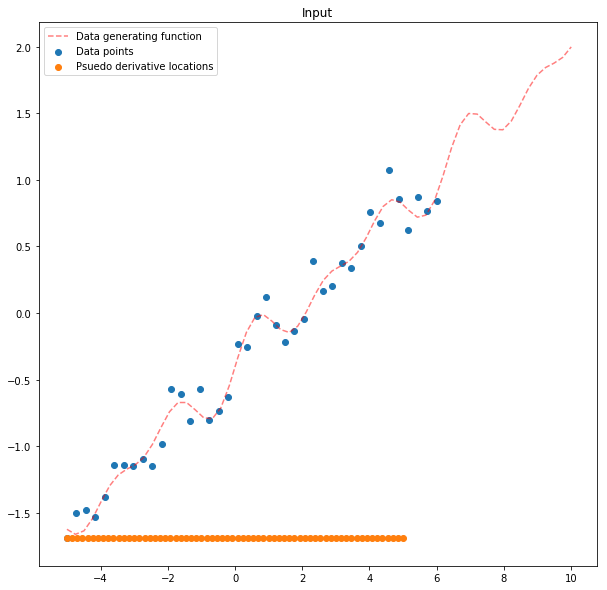

In [46]:
def func(x):
    return (np.sin(x*3)*0.5+np.sin(x*2)*0.5+x)



xdata = np.linspace(-5,6,40)
ydata = func(xdata) + np.random.normal(0,0.5,size=len(xdata))
x = np.linspace(-5,10,60)
y = func(x) 
ycombined = preprocessing.scale(np.append(ydata,y))
ydata = ycombined[:len(xdata)]
y = ycombined[len(xdata):]

plt.figure(figsize=(10,10))
plt.scatter(xdata,ydata,label="Data points")
plt.plot(x,y,'r--',alpha=0.5,label="Data generating function")
plt.scatter(xm,np.zeros_like(xm)+np.min(ycombined),label="Psuedo derivative locations")
plt.title('Input')

plt.legend()
plt.savefig("Input %s.png"%(time.ctime()))

plt.show()

In [29]:
sig =0.3
v= 0.000001

posterior_data = dict(
    N1 = len(xdata),
    x1 = xdata,
    y1 = ydata,
    N2 = len(x),
    x2 = x,
    sig_var = sig
)

mono_posterior_data = dict(
    N1 = len(xdata),
    x1 = xdata,
    y1 = ydata,
    Nm = len(xm),
    xm = xm,
    m = m,
    N2 = len(x),
    x2 = x,
    v = v,
    sig_var = sig
)

In [30]:
posterior_fit = posterior_model.sampling(data=posterior_data)
print(posterior_fit)

Inference for Stan model: anon_model_f2c9e4d4a8ca5ef24cd8c45a8059b229.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho       5.72    2.25   5.03    0.8   0.98   4.99   9.14  17.13      5   1.38
alpha     1.17    0.15   0.49   0.58    0.8   1.04   1.42    2.4     11   1.15
eta[0]   -1.56    0.17   0.55  -2.71  -1.94  -1.51  -1.12  -0.67     10   1.15
eta[1]    0.44    0.58   1.16  -1.42  -0.69   0.71   1.35   2.47      4   1.62
eta[2]    0.18    0.04   0.75  -1.26  -0.32   0.17   0.67    1.7    351   1.02
eta[3]   -0.23    0.24   0.95  -1.96  -0.88  -0.28   0.35   1.85     16   1.08
eta[4]   -0.32    0.36   1.07  -2.27  -1.11  -0.36   0.41   1.83      9   1.17
eta[5]   -0.05    0.18   0.99  -1.98  -0.73  -0.07   0.62   1.91     29   1.05
eta[6]    0.22    0.02   0.94  -1.66  -0.38   0.22   0.84   2.05   3246    1.0
eta[7]    0.21    0.0

In [31]:
mono_posterior_fit = mono_posterior_model.sampling(data=mono_posterior_data)
print(mono_posterior_fit)

Inference for Stan model: anon_model_039f5d1b4eb3351abf04c95ec4c9de0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
rho        8.91    0.14   3.95   3.32   5.97   8.34  11.06   18.3    849    1.0
alpha      1.39    0.01   0.49   0.67   1.03   1.31   1.67   2.56   1183    1.0
eta[0]    -1.29    0.01   0.44  -2.31  -1.54  -1.22  -0.97  -0.63    939   1.01
eta[1]     1.29    0.02   0.62   0.25   0.83   1.22   1.67   2.67   1204    1.0
eta[2]     0.17    0.02   0.97  -1.69  -0.51   0.16   0.82   2.08   4000    1.0
eta[3]     0.14    0.01   0.94  -1.61  -0.52   0.13   0.79   2.01   4000    1.0
eta[4]     0.13    0.01   0.93  -1.69   -0.5   0.13   0.74   1.98   4000    1.0
eta[5]     0.17    0.01   0.92  -1.66  -0.45   0.17   0.81   1.92   4000    1.0
eta[6]     0.13    0.02   0.98  -1.76  -0.53   0.14   0.79   2.07   4000    1.0
eta[7]     

In [32]:
sim_posterior = posterior_fit.extract(permuted=True)['y2']
mono_sim_posterior = mono_posterior_fit.extract(permuted=True)['y2']

p_mean = np.mean(sim_posterior,axis=0)
p_std = np.std(sim_posterior,axis=0)

m_p_mean = np.mean(mono_sim_posterior,axis=0)
m_p_std = np.std(mono_sim_posterior,axis=0)

p_q5 = np.percentile(sim_posterior, 5, axis=0)
p_q95 = np.percentile(sim_posterior, 95, axis=0)

m_p_q5 = np.percentile(mono_sim_posterior, 5, axis=0)
m_p_q95 = np.percentile(mono_sim_posterior, 95, axis=0)

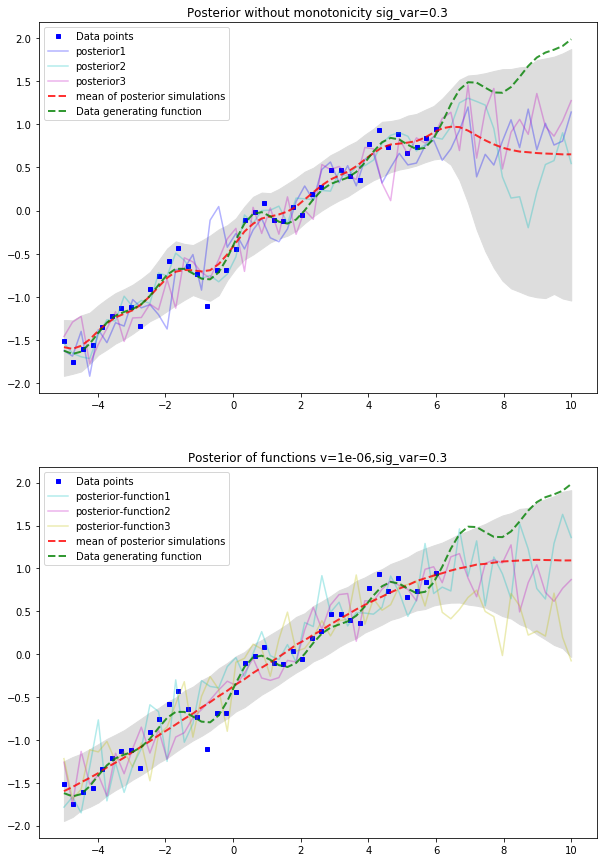

In [42]:
c = ['b', 'c', 'm', 'y']
p = np.random.randint(sim_posterior.shape[0],size=3)
pp = np.random.randint(mono_sim_posterior.shape[0],size=3)


fig,ax = plt.subplots(2,1)
fig.set_size_inches(10,15)
ax[0].set_title('Posterior without monotonicity sig_var={}'.format(sig))
ax[0].plot(xdata, ydata, 'bs', ms=4,label="Data points")#  
ax[0].plot(x, sim_posterior[p[0]], c[0],alpha=0.3,label="posterior1")
ax[0].plot(x, sim_posterior[p[1]], c[1],alpha=0.3,label="posterior2")
ax[0].plot(x, sim_posterior[p[2]], c[2],alpha=0.3,label="posterior3")
ax[0].plot(x, p_mean,'r--',alpha=0.8,lw=2,label="mean of posterior simulations")
ax[0].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
ax[0].fill_between(x, p_q5, p_q95, color="#dddddd")
ax[0].legend()


#plt.subplot(2,2,2)
ax[1].set_title('Posterior of functions v={},sig_var={}'.format(v,sig))
ax[1].plot(xdata, ydata, 'bs', ms=4,label="Data points")#
ax[1].fill_between(x, m_p_q5, m_p_q95, color="#dddddd")
ax[1].plot(x, mono_sim_posterior[pp[0]], c[1],alpha=0.3,label="posterior-function1")
ax[1].plot(x, mono_sim_posterior[pp[1]], c[2],alpha=0.3,label="posterior-function2")
ax[1].plot(x, mono_sim_posterior[pp[2]], c[3],alpha=0.3,label="posterior-function3")
ax[1].plot(x, m_p_mean, 'r--',alpha=0.8, lw=2,label="mean of posterior simulations")
ax[1].plot(x,y,'g--',alpha=0.8,lw=2,label="Data generating function")
ax[1].legend()

plt.savefig("Posterior %s.png"%(time.ctime()))
plt.show()